### Todo
* Add geographical repartition (cartogramm) heatmap by %age of parrainage by candidate by region
* Does the "parrain" respect his own political color ?
* Geographical diversity
* Quel département soutient quel candidat ?

# Sources
* Autre projet : Le Monde 20220222 : https://www.lemonde.fr/les-decodeurs/article/2022/02/01/election-presidentielle-2022-visualisez-les-parrainages-obtenus-par-les-candidats_6111902_4355770.html
* Population : INSEE 20220222 : https://www.insee.fr/fr/statistiques/4277602?sommaire=4318291#consulter
* Couleur politique : Le Monde 20220222 : https://www.lemonde.fr/les-decodeurs/article/2021/06/02/presidentielle-2022-qui-sont-les-candidats-declares-et-pressentis_6082545_4355770.html
* Coulmont : https://twitter.com/coulmont
* Le Monde : https://www.lemonde.fr/les-decodeurs/article/2022/02/22/presidentielle-2022-le-tableau-de-bord-des-parrainages-sondages-et-temps-de-parole_6114816_4355770.html
* France Télévision : https://www.francetvinfo.fr/elections/presidentielle/candidats/presidentielle-pourquoi-la-limite-de-50-parrainages-par-departement-pourrait-creer-des-surprises_4977189.html#xtor=CS2-765-%5Bautres%5D-
* Répertoire national des élus (RNE) : https://www.data.gouv.fr/fr/datasets/repertoire-national-des-elus-1/
* Départements français, shapefile : https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/

In [1]:
import contextily as ctx
from datetime import date, datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

DATA_URL = 'https://presidentielle2022.conseil-constitutionnel.fr/telechargement/parrainagestotal.json'
DATA_FOLDER = 'data'
DATA_FILE = 'parrainagestotal-20220303.json'
LAST_DATE = '2022-03-03'
RESULTS_FOLDER = 'results'
SOURCE_FOLDER = 'sources'
THRESHOLD = 500

plt.rcParams['figure.figsize'] = [9, 11]

In [2]:
# Save today's file
#response = requests.get(DATA_URL).json()
#data = pd.json_normalize(response)
#today = date.today().strftime('%Y%m%d')
#filename = f'parrainagestotal-{today}.json'
#data.to_json(f'{DATA_FOLDER}/{filename}', orient='records', indent=2, force_ascii=False)

In [3]:
female_color = '#FC363B'
male_color = '#2766F6'
candidates = {
    'PÉCRESSE Valérie': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#419BF9'
    },
    'MACRON Emmanuel': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#FEA419'
    },
    'HIDALGO Anne': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#F76083'
    },
    'ROUSSEL Fabien': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#DB304F'
    },
    'JADOT Yannick': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#31A31A'
    },
    'LASSALLE Jean': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#AF48B2'
    },
    'ARTHAUD Nathalie': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#BA0523'
    },
    'MÉLENCHON Jean-Luc': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#DB304F'
    },
    'DUPONT-AIGNAN Nicolas': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#7A4724'
    },
    'LE PEN Marine': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#7A4724'
    },
    'ZEMMOUR Éric': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#7A4724'
    },
    'ASSELINEAU François': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#AF48B2'
    },
    'POUTOU Philippe': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#BA0523'
    },
    'KAZIB Anasse': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#BA0523'
    },
    'TAUBIRA Christiane': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#F76083'
    },
    'THOUY Hélène': {
        'gender': 'female',
        'gender_color': female_color,
        'political_color': '#AF48B2'
    },
    'KOENIG Gaspard': {
        'gender': 'male',
        'gender_color': male_color,
        'political_color': '#0890C6'
    }
}

# 2. Load all data
sponsorships = pd.read_json(os.path.join(DATA_FOLDER, DATA_FILE))

# Transform
## Rename columns
columns = {
    'Mandat': 'mandat'
}
sponsorships = sponsorships.rename(columns=columns)
## Number of sponsorships
total_sponsorships = len(sponsorships)
## Gender
genders_by_civility = {
    'M.': 'male',
    'Mme': 'female'
}
sponsorships['gender_calculated'] = sponsorships['Civilite'].apply(lambda x: genders_by_civility.get(x, 'unknown'))
## Mandate
mandates = {
    "Conseiller de Paris": "Conseiller de Paris",
    "Conseiller départemental": "Conseiller départemental",
    "Conseiller métropolitain de Lyon": "Conseiller métropolitain de Lyon",
    "Conseiller régional": "Conseiller régional",
    "Conseiller à l'Assemblée des Français de l'étranger": "Conseiller à l'Assemblée des Français de l'étranger",
    "Conseillère de Paris": "Conseiller de Paris",
    "Conseillère départementale": "Conseiller départemental",
    "Conseillère métropolitaine de Lyon": "Conseiller métropolitain de Lyon",
    "Conseillère régionale": "Conseiller régional",
    "Conseillère à l'Assemblée des Français de l'étranger": "Conseiller à l'Assemblée des Français de l'étranger",
    "Député": "Député",
    "Députée": "Député",
    "Maire": "Maire",
    "Maire d'arrondissement": "Maire d'arrondissement",
    "Maire délégué d'une commune associée ou d'une commune déléguée": "Maire délégué d'une commune associée ou d'une commune déléguée",
    "Maire déléguée d'une commune associée ou d'une commune déléguée": "Maire délégué d'une commune associée ou d'une commune déléguée",
    "Membre d'une assemblée d'une collectivité territoriale d'outre-mer à statut particulier": "Membre d'une assemblée d'une collectivité territoriale d'outre-mer à statut particulier",
    "Membre de l'Assemblée de Corse": "Membre de l'Assemblée de Corse",
    "Président d'un EPCI à fiscalité propre": "Président d'un EPCI à fiscalité propre",
    "Président de la Polynésie française": "Président de la Polynésie française",
    "Président du conseil consulaire": "Président du conseil consulaire",
    "Présidente d'un EPCI à fiscalité propre": "Président d'un EPCI à fiscalité propre",
    "Présidente du conseil consulaire": "Président du conseil consulaire",
    "Représentant français au Parlement européen": "Représentant français au Parlement européen",
    "Représentante française au Parlement européen": "Représentant français au Parlement européen",
    "Sénateur": "Sénateur",
    "Sénatrice": "Sénateur"
}
sponsorships['mandat_calculated'] = sponsorships['mandat'].apply(lambda x: mandates.get(x, 'unknown'))
## Population by city
cities = pd.read_csv(os.path.join(SOURCE_FOLDER, 'communes.csv'), sep=';').get(['COM', 'PTOT']).set_index('COM').to_dict()['PTOT']
sponsorships['population_calculated'] = sponsorships['Circonscription'].apply(lambda x: cities.get(x, 0))
## DatePublication
sponsorships['DatePublication'] = sponsorships['DatePublication'].apply(lambda x: x.replace('T00:00:00', ''))

sponsorships

,Civilite,Nom,Prenom,mandat,Circonscription,Departement,Candidat,DatePublication,gender_calculated,mandat_calculated,population_calculated
0,M.,CORDIVAL,Gilles,Maire,Mont-Saint-Père,Aisne,ARTHAUD Nathalie,2022-02-01,male,Maire,709
1,Mme,VALLIET,Odile,Maire,Crupilly,Aisne,ARTHAUD Nathalie,2022-02-01,female,Maire,66
2,M.,GUEYRAUD,Jean-Marie,Maire,Saint-Auban-d'Oze,Hautes-Alpes,ARTHAUD Nathalie,2022-02-01,male,Maire,85
3,Mme,NOUVEL,Marie-Claude,Maire,Seignalens,Aude,ARTHAUD Nathalie,2022-02-01,female,Maire,31
4,M.,GAINCHE,Jean-Paul,Maire,Langrolay-sur-Rance,Côtes-d'Armor,ARTHAUD Nathalie,2022-02-01,male,Maire,997
...,...,...,...,...,...,...,...,...,...,...,...
12746,M.,HAAPII,Basile,Maire délégué d'une commune associée ou d'une ...,Anaa,Polynésie française,ZEMMOUR Éric,2022-03-03,male,Maire délégué d'une commune associée ou d'une ...,0
12747,M.,TCHOUNG,Victor,Maire délégué d'une commune associée ou d'une ...,Hitiaa O Te Ra,Polynésie française,ZEMMOUR Éric,2022-03-03,male,Maire délégué d'une commune associée ou d'une ...,0
12748,M.,TEREMIHI,Pikiragi,Maire délégué d'une commune associée ou d'une ...,Makemo,Polynésie française,ZEMMOUR Éric,2022-03-03,male,Maire délégué d'une commune associée ou d'une ...,0
12749,Mme,TERITO,Jeanine,Maire déléguée d'une commune associée ou d'une...,Hitiaa O Te Ra,Polynésie française,ZEMMOUR Éric,2022-03-03,female,Maire délégué d'une commune associée ou d'une ...,0


# Global

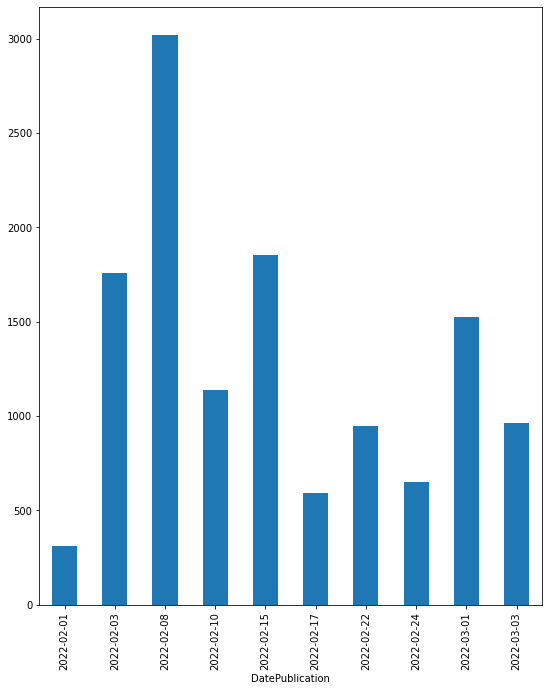

In [4]:
# Number of new sponsorships for each new date
df_count = sponsorships.groupby('DatePublication').count().reset_index().get(['DatePublication', 'Candidat'])
df_count.plot(x='DatePublication', y='Candidat', kind='bar', legend=False)
plt.show()

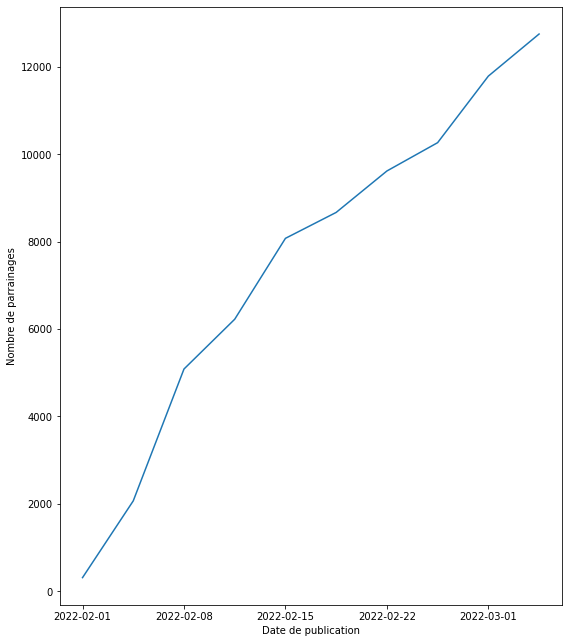

In [5]:
# Number of sponsorships among time
df_count['cumsum'] = df_count['Candidat'].cumsum()
df_count.plot(x='DatePublication', y='cumsum', legend=False)
plt.xlabel('Date de publication')
plt.ylabel('Nombre de parrainages')
plt.savefig(f'{RESULTS_FOLDER}/sponsorships_by_time.png', facecolor='white')
plt.show()

In [6]:
# List all candidates and their sponsorships count sorted by count descending
df_candidates = sponsorships.groupby('Candidat').count().reset_index().get(['Candidat', 'Civilite']).rename(columns={'Civilite': 'total'}).sort_values('total', ascending=False)
df_candidates

,Candidat,total
45,PÉCRESSE Valérie,2556
31,MACRON Emmanuel,1974
19,HIDALGO Anne,1387
39,MÉLENCHON Jean-Luc,873
59,ZEMMOUR Éric,721
21,JADOT Yannick,689
28,LASSALLE Jean,620
49,ROUSSEL Fabien,619
30,LE PEN Marine,603
12,DUPONT-AIGNAN Nicolas,582


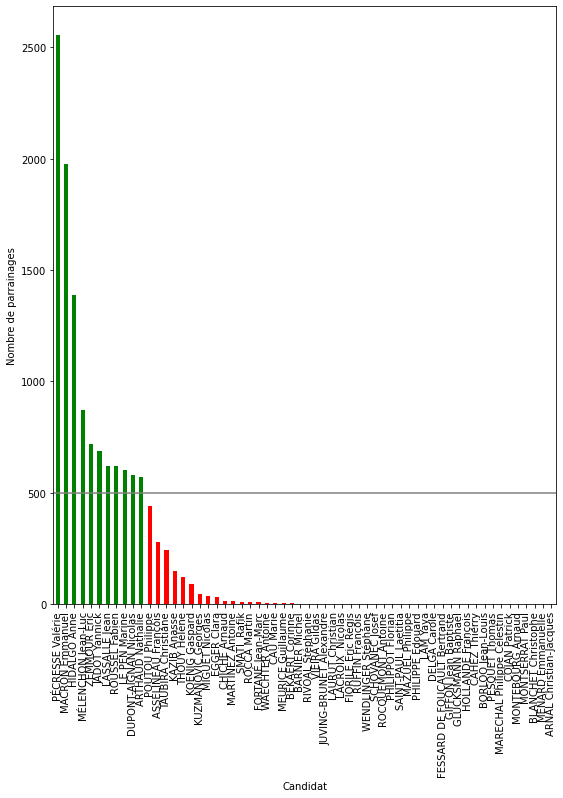

In [7]:
# Number of sponsorships by candidate
axes = df_candidates.plot(x='Candidat', y='total', kind='bar', color=df_candidates['total'].apply(lambda x: 'green' if x >= THRESHOLD else 'red'), legend=False)
axes.axhline(THRESHOLD, color='gray')
plt.xlabel('Candidat')
plt.ylabel('Nombre de parrainages')
plt.savefig(f'{RESULTS_FOLDER}/sponsorships_by_candidate.png', facecolor='white')
plt.show()

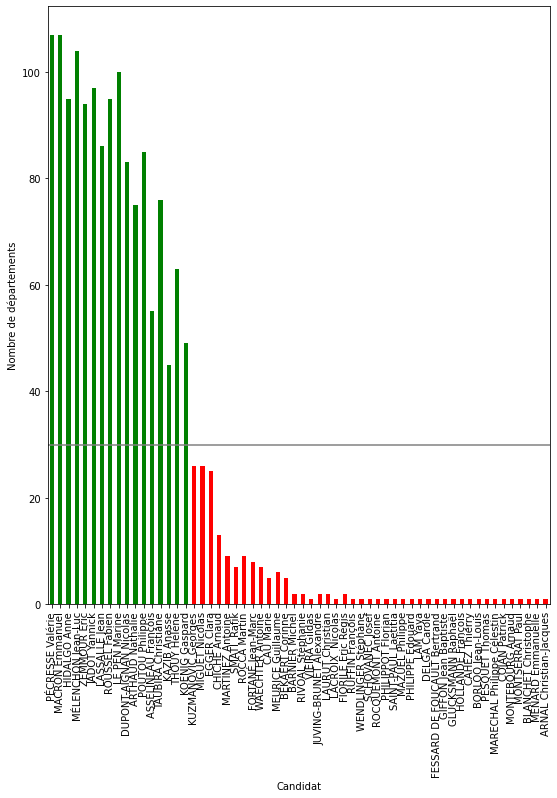

In [8]:
# Number de departments by candidate
department_threshold = 30
df = sponsorships.groupby(['Candidat', 'Departement'])['Candidat'].count().unstack('Departement')
df['total'] = df.sum(axis=1)
df = df.sort_values('total', ascending=False).drop(['total'], axis=1).notna().sum(axis=1)
ax = df.plot(kind='bar', color=df.apply(lambda x: 'green' if x >= department_threshold else 'red'))
ax.axhline(department_threshold, color='gray')
plt.xlabel('Candidat')
plt.ylabel('Nombre de départements')
plt.savefig(f'{RESULTS_FOLDER}/number_of_department_by_candiate.png', facecolor='white')
plt.show()

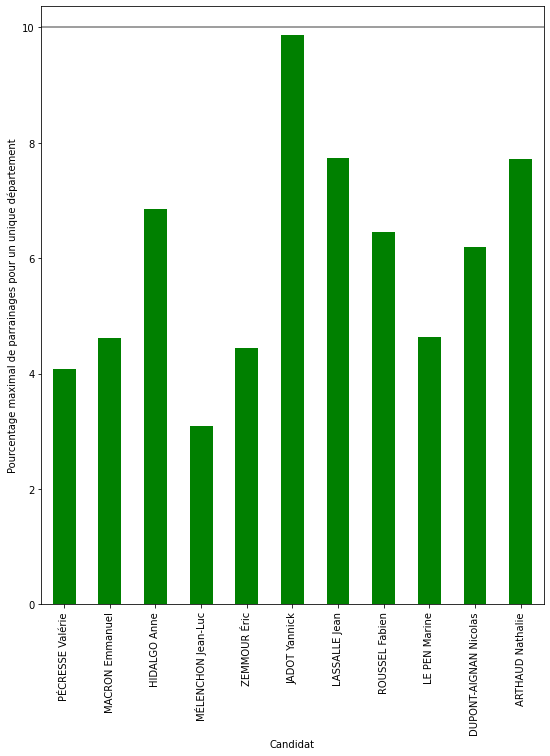

In [9]:
# Maximum rate of sponsorships by department by candidate
df = sponsorships.groupby(['Candidat', 'Departement'])['Candidat'].count().unstack('Departement').fillna(0)
df['total'] = df.sum(axis=1)
df = df.sort_values('total', ascending=False).query(f'total > {THRESHOLD}')
df['max'] = df.loc[:, df.columns != 'total'].max(axis=1)
df['percent'] = round(df['max'] / df['total'] * 100, 2)
df = df.get('percent')#.unstack('Candidat')
ax = df.plot(kind='bar', color=df.apply(lambda x: 'red' if float(x) > 10 else 'green'), legend=False)
ax.axhline(10, color='gray')
plt.ylabel('Pourcentage maximal de parrainages pour un unique département')
plt.savefig(f'{RESULTS_FOLDER}/max_rate_by_department_by_candidate.png', facecolor='white')
plt.show()

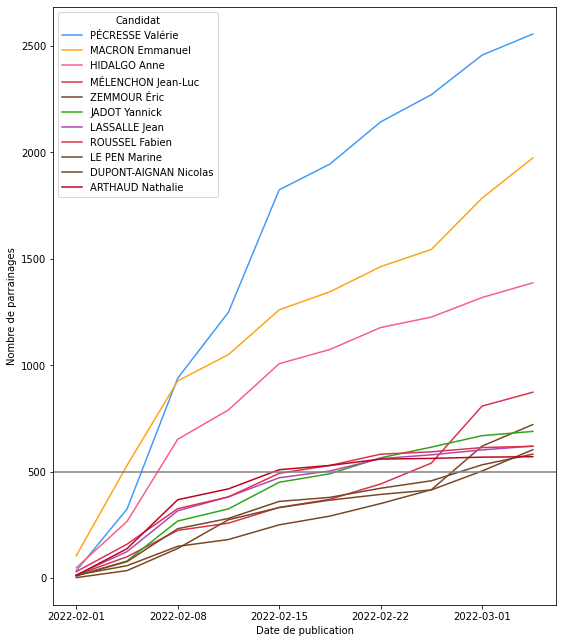

In [10]:
# Number of sponsorships by candidate over the time
df = sponsorships.groupby(['Candidat', 'DatePublication'])['Candidat'].count().unstack('DatePublication').fillna(0).reset_index()
df = df.set_index('Candidat').cumsum(axis=1).query(f'`{LAST_DATE}` > {THRESHOLD}').sort_values(LAST_DATE, ascending=False).transpose()
colors = [candidates.get(column, {}).get('political_color', 'black') for column in df.columns]
ax = df.plot(color=colors)
ax.axhline(THRESHOLD, color='gray')
plt.xlabel('Date de publication')
plt.ylabel('Nombre de parrainages')
plt.savefig(f'{RESULTS_FOLDER}/sponsorships_by_candidate_by_time.png', facecolor='white', bbox_inches = 'tight')
plt.show()

# Marrainages

## Global

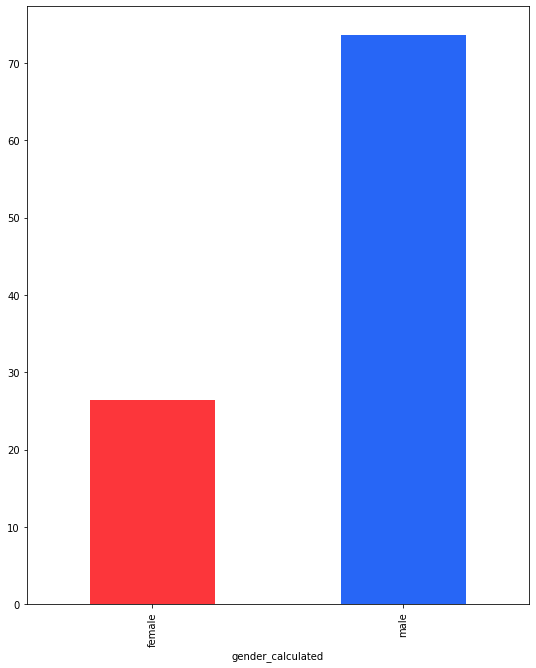

In [11]:
# Sponsorships by gender
df_gender_percent = sponsorships.groupby('gender_calculated').count().reset_index().get(['gender_calculated', 'Candidat']).rename(columns={'Candidat': 'count'})
df_gender_percent['gender_calculated_percent'] = df_gender_percent['count'].apply(lambda x: round(x / total_sponsorships * 100, 2))
df_gender_percent.plot(x='gender_calculated', y='gender_calculated_percent', kind='bar', color=[female_color, male_color], legend=False)
plt.show()

## By candidate

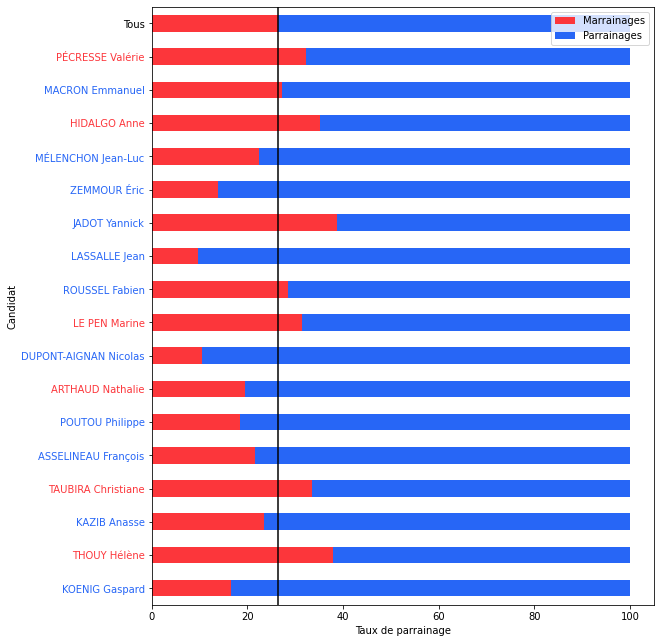

In [12]:
# Sponsorships by gender by candidates
def get_color(tick):
    return candidates.get(tick.get_text(), {}).get('gender_color', 'black')

df = sponsorships.groupby(['Candidat', 'gender_calculated'])['Candidat'].count().unstack('gender_calculated').fillna(0).reset_index()
df['total'] = df.sum(axis=1)
df['female_percent'] = round(df['female'] / df['total'] * 100, 2)
df['male_percent'] = round(df['male'] / df['total'] * 100, 2)
female_calculated_percent = df_gender_percent['gender_calculated_percent'][0]
df.loc[-1] = ['Tous', df_gender_percent['count'][0], df_gender_percent['count'][1], total_sponsorships, female_calculated_percent, df_gender_percent['gender_calculated_percent'][1]]
df.index = df.index + 1
df = df.query('total > 50').sort_values('total').set_index('Candidat').get(['female_percent','male_percent']).rename(columns={'female_percent': 'Marrainages', 'male_percent': 'Parrainages'})
axes = df.plot(kind='barh', stacked=True, color=[female_color, male_color], legend=False)
axes.axvline(female_calculated_percent, color='black')
axes.legend()
[tick.set_color(get_color(tick)) for tick in axes.get_yticklabels()]
plt.xlabel('Taux de parrainage')
plt.ylabel('Candidat')
plt.savefig(f'{RESULTS_FOLDER}/gender_rate_by_candidate.png', facecolor='white', bbox_inches = 'tight')
plt.show()

# Mandat

## Total

In [13]:
sponsorships_mandates = sponsorships.groupby('mandat_calculated').count().rename(columns={'Civilite': 'count'}).sort_values('count', ascending=False)['count']
sponsorships_mandates

mandat_calculated
Maire                                                                                      8253
Conseiller départemental                                                                   1518
Conseiller régional                                                                        1064
Député                                                                                      523
Maire délégué d'une commune associée ou d'une commune déléguée                              430
Sénateur                                                                                    291
Conseiller de Paris                                                                         127
Membre d'une assemblée d'une collectivité territoriale d'outre-mer à statut particulier     120
Conseiller métropolitain de Lyon                                                            103
Président du conseil consulaire                                                              72
Président d'un EPCI à 

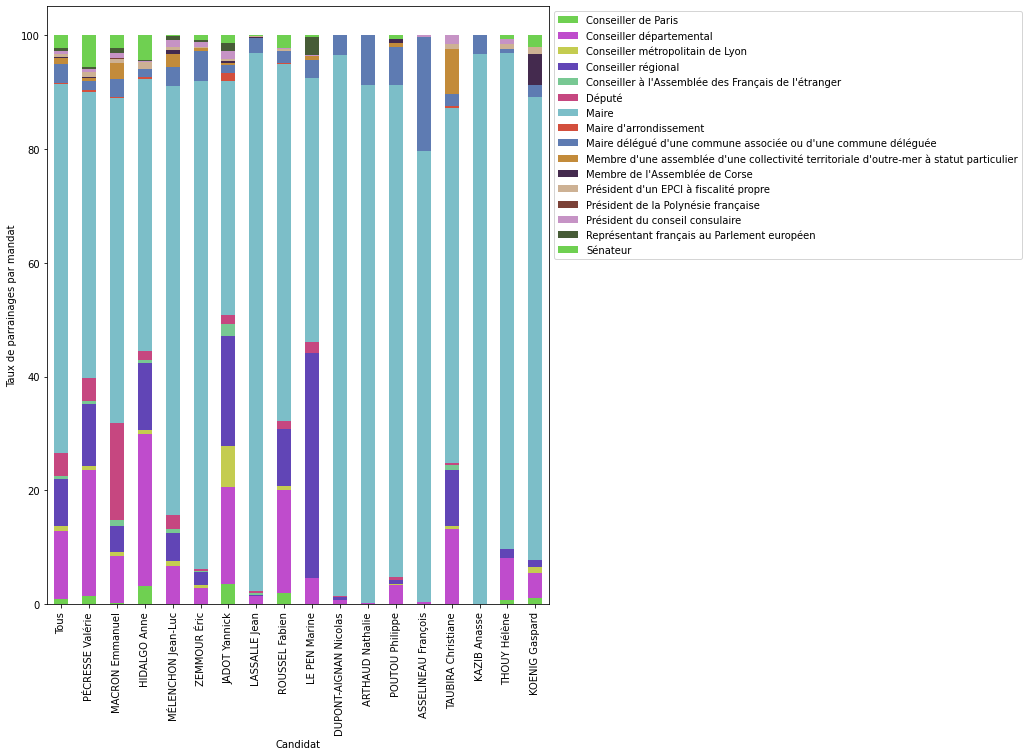

In [14]:
# Sponsorships by mandat by candidat
colors = ['#6FD051', '#BF4CCC', '#C4CC50', '#6145B6', '#78C893', '#C64780', '#7CBEC8', '#D34F3D', '#5E7BB2', '#C38B3A', '#442A4E', '#CDB194', '#7B4137', '#C693C5', '#475C37']
df = sponsorships.groupby(['Candidat', 'mandat_calculated'])['Candidat'].count().unstack('mandat_calculated').fillna(0).reset_index()
# Add a row at first position with national values
all = [sponsorships_mandates[key] for key in df.keys() if key != 'Candidat']
all.insert(0, 'Tous')
df.loc[-1] = all
df.index = df.index + 1
# Add a new column with the sum of sponsorships
df['total'] = df.sum(axis=1)
# Transform each row in percentage of sponsorships
for i, row in df.iterrows():
    for j, value in row.items():
        if j not in ['Candidat', 'total']:
            value_percent = round(value / row['total'] * 100, 2)
            df.at[i, j] = value_percent
df = df.query('total > 50')
df = df.sort_values('total', ascending=False)
df = df.set_index('Candidat')
df.loc[:, df.columns != 'total'].plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Candidat')
plt.ylabel('Taux de parrainages par mandat')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig(f'{RESULTS_FOLDER}/mandates_rate_by_candiate.png', facecolor='white', bbox_inches = 'tight')
plt.show()

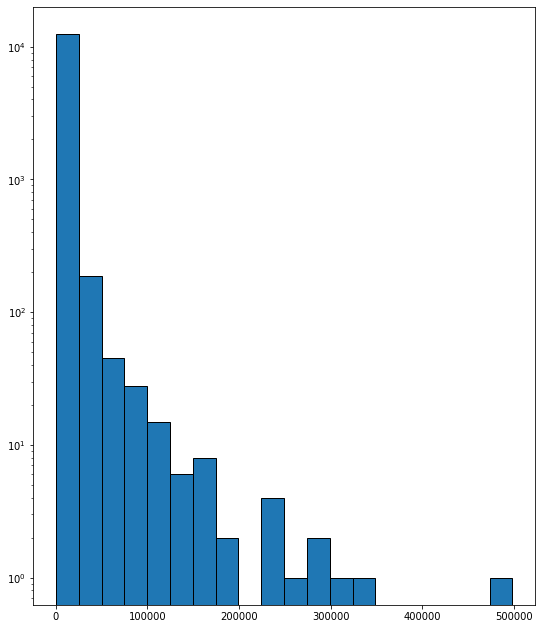

In [15]:
plt.hist(sponsorships['population_calculated'], bins=20, log=True, edgecolor='black')
plt.show()

/home/alhote/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


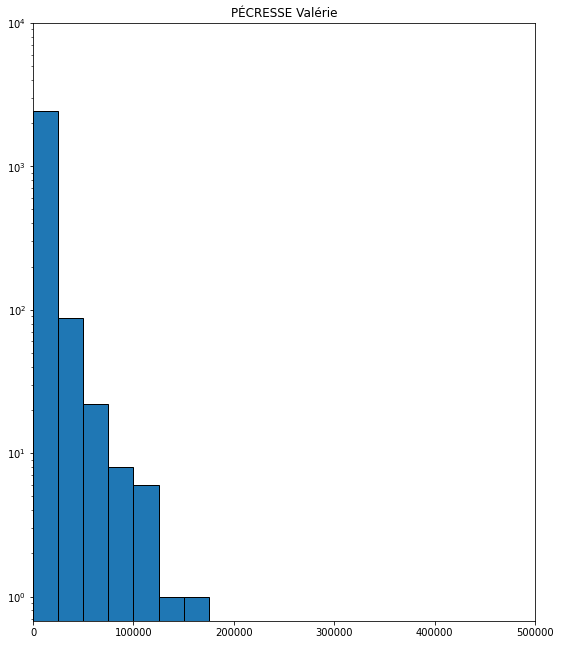

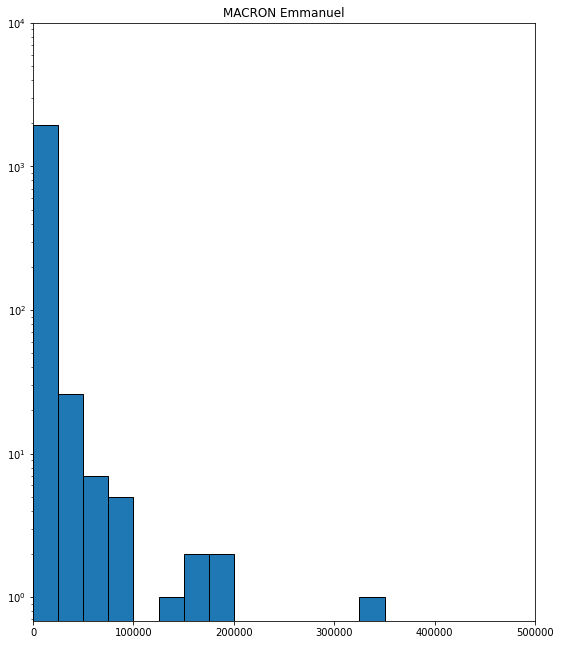

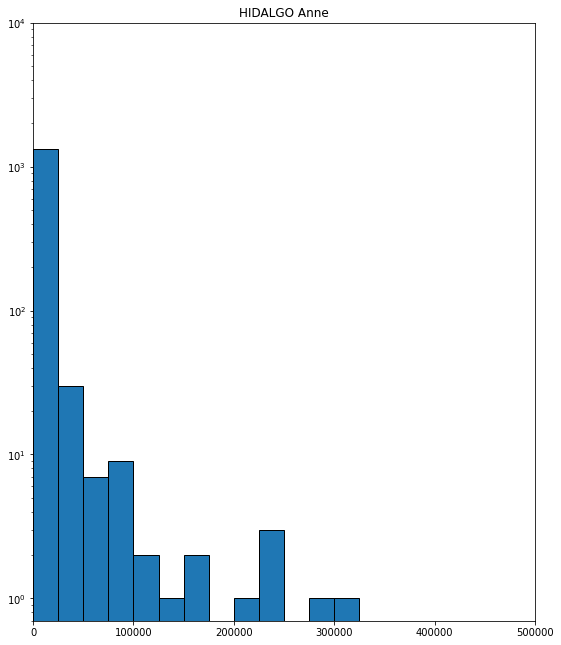

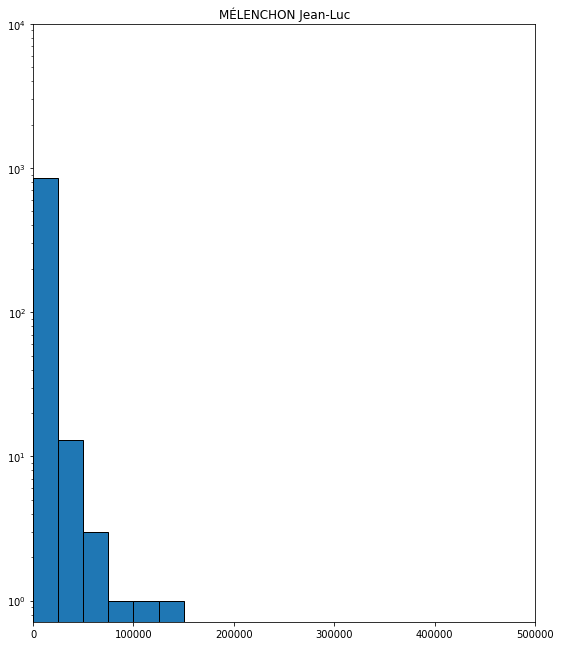

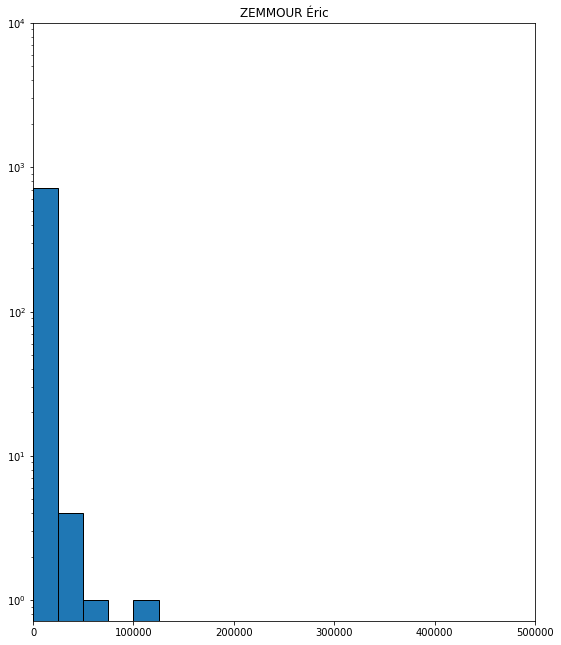

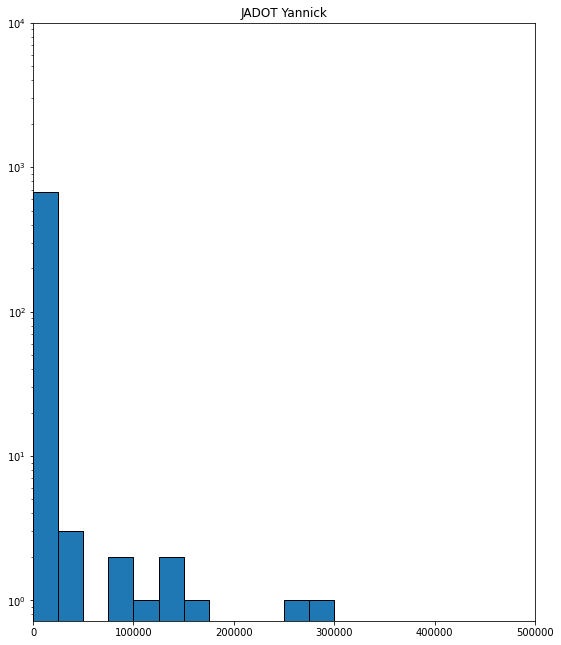

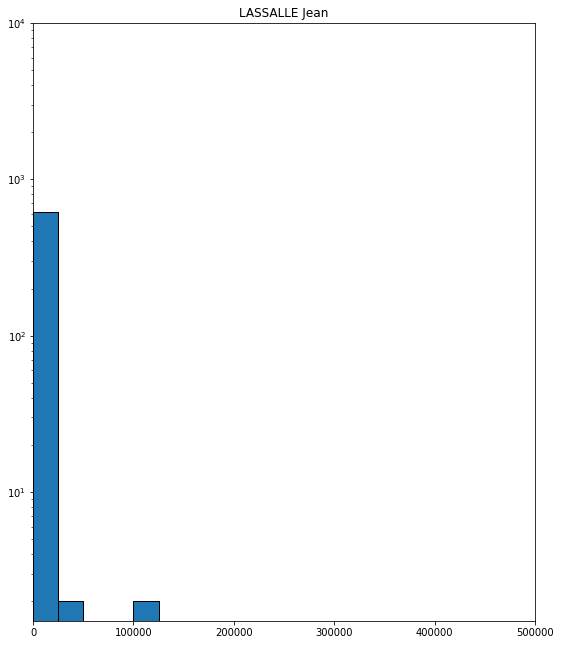

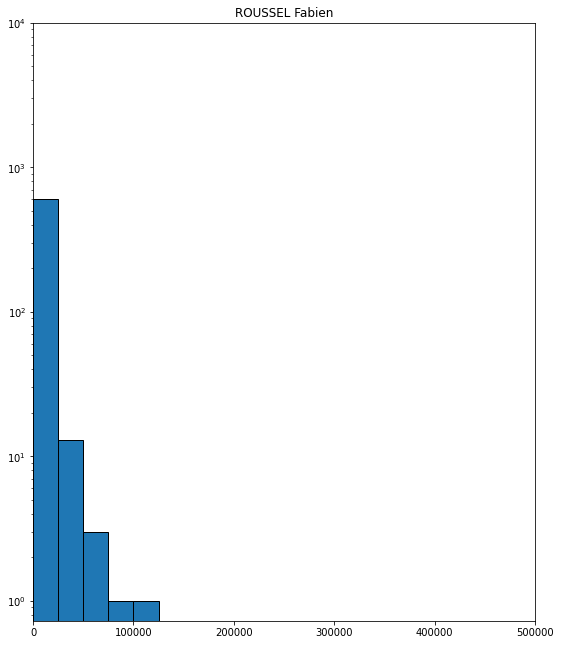

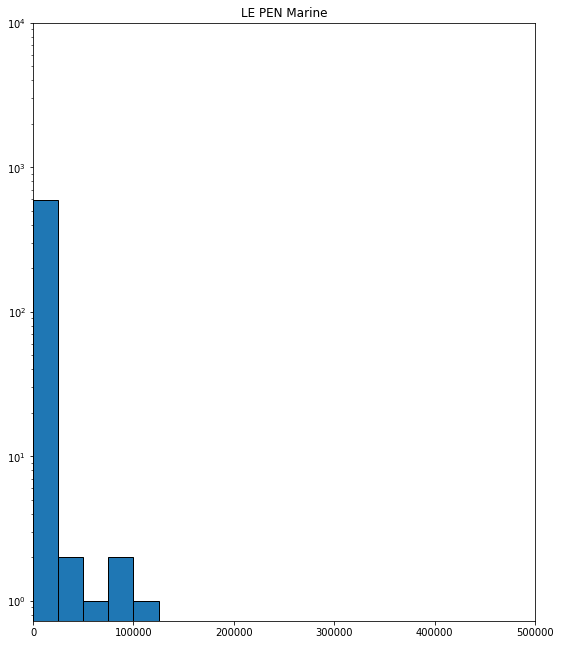

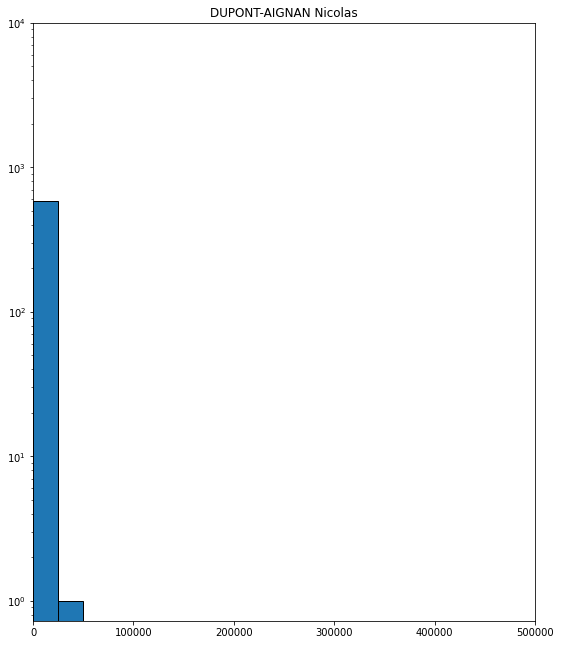

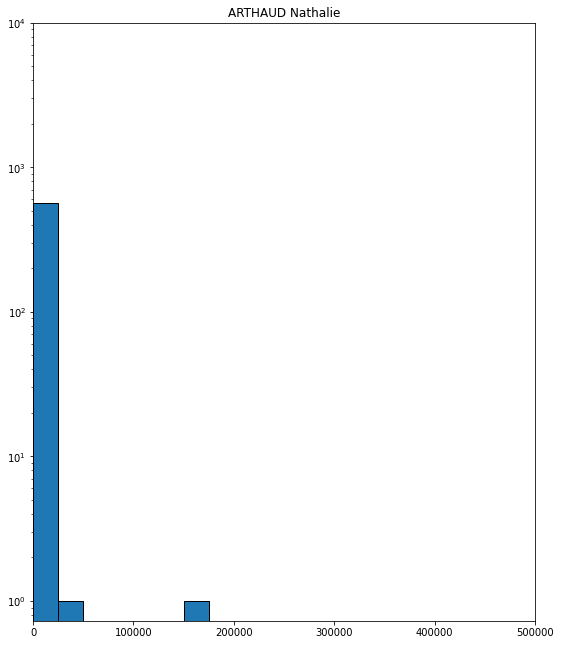

In [16]:
for candidat in df_candidates.query(f'total > {THRESHOLD}')['Candidat']:
    hist = sponsorships.loc[sponsorships['Candidat'] == candidat]
    plt.hist(hist['population_calculated'], bins=range(0, 500000, 25000), log=True, edgecolor='black')
    plt.title(candidat)
    plt.xlim(0, 500000)
    plt.ylim(0, 10000)
    plt.show()

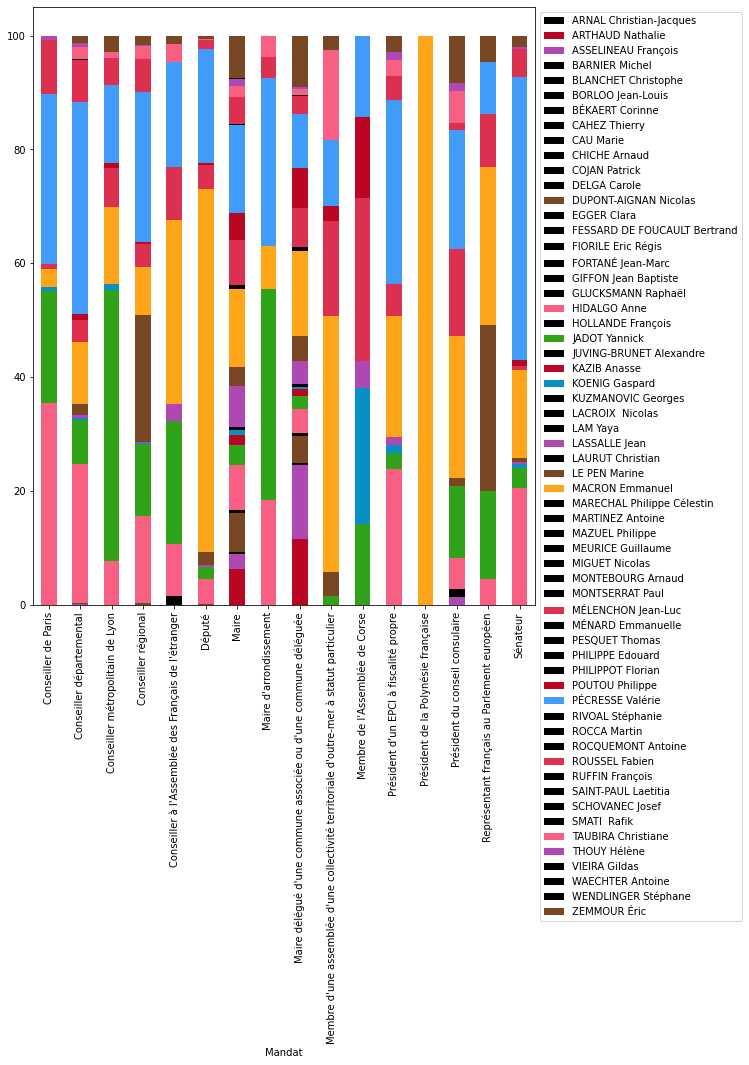

In [17]:
# Quel mandat soutien quel candidat ? (eg. Qui ont parrainé les "Membre de l'Assemblée de Corse" ?)
df = sponsorships.groupby(['mandat_calculated', 'Candidat'])['mandat_calculated'].count().unstack('Candidat').fillna(0)
df['total'] = df.sum(axis=1)
for i, row in df.iterrows():
    for j, item in row.iteritems():
        df[j][i] = df[j][i] / df['total'][i] * 100
colors = [candidates.get(column, {}).get('political_color', 'black') for column in df.columns]
df.loc[:, df.columns != 'total'].plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Mandat')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig(f'{RESULTS_FOLDER}/candidates_rate_by_mandate.png', facecolor='white', bbox_inches = 'tight')
plt.show()

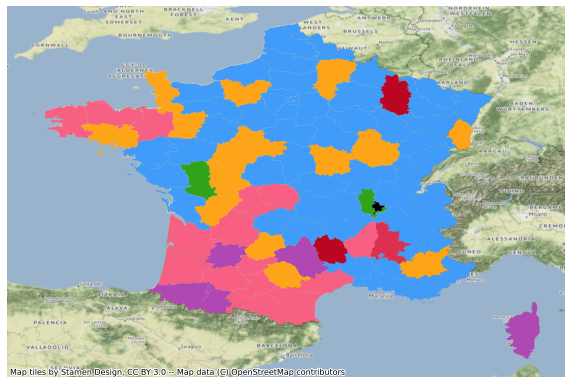

In [18]:
# Which department mostly sponsors which candidate ?
df = sponsorships.groupby(['Departement', 'Candidat'])['Departement'].count().unstack('Candidat').fillna(0).idxmax(axis=1)
def get_name(name):
    if name == 'Territoire-de-Belfort':
        return 'Territoire de Belfort'
    if name == 'Métropole de Lyon':
        return None
    return name

departments = gpd.read_file(f'{SOURCE_FOLDER}/departements-20170102.shp', encoding='utf-8')
departments = departments[~departments.code_insee.str.startswith('97')]
departments['color'] = departments['nom'].apply(lambda x: candidates.get(df.get(get_name(x)), {}).get('political_color', 'black'))
fig,ax = plt.subplots(figsize=(10, 10))
departments.plot(ax = ax, color=departments['color'])
ctx.add_basemap(ax, crs = departments.crs.to_string())
ax.set_axis_off()
plt.savefig(f'{RESULTS_FOLDER}/candidates_by_department.png', facecolor='white', bbox_inches = 'tight')
plt.show()